# Dauphine 203 - Machine learning competition: Predict emerging countries corporates default risk

## Part 2: Machine learning prediction

***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
%matplotlib inline

df_train = pd.read_csv('ML_train.csv', index_col=0)
df_test = pd.read_csv('ML_test.csv', index_col=0)
indices = pd.read_csv('test.csv')['id']

The user tested feature selection, e.g. selecting features based on their *a priori* ability to discriminate between defaults and non-defaults, but ended up using all the features and relied on implicit feature selection through ensemble learning and regularization penalties.

In [2]:
# 0.8447
select_1 = ['f1','f3','f5','f6','f11','f12','f16','f24','f30','f14','f20','f7',
            'f33','f35','f45','f46','f47', 'f48','f50','f52','f55','f57','f58',
            'f62']

# 0.83
select_1_mc = ['f3','f5','f6','f12','f14','f16','f24','f30','f33','f35','f45',
               'f46','f48','f50','f52','f55','f57','f58']

# 0.8447
select_2 = ['f1','f4','f5','f6','f7','f8','f9','f12','f13','f14','f15','f16','f17',
            'f19','f23','f25','f26','f28','f30','f31','f33','f34','f37','f41',
            'f46','f48','f50','f52','f53','f54','f55','f59','f60','f62','f63',
            'f64']

# Final selection
select_all = df_train.drop('label', axis=1).columns

# Choice
features = select_all

The user attempted to use oversampling to correct class imbalance, but failed to improve results. This is in line with research that shows that oversampling leads to overfitting the characteristics of the "minor" class. Nevertheless, the code for implementing oversampling is provided.

The following does the usual train/validation split for model fitting.

In [3]:
from sklearn.model_selection import train_test_split

X = df_train[features]
df_test = df_test[features]

Y = df_train['label']
X_test = df_test

# OVERSAMPLING
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# ros = SMOTE(ratio='minority', random_state=0)
# X, Y = ros.fit_sample(X, Y)
# print(sorted(Counter(Y).items()))

# X = pd.DataFrame(X, columns=X_test.columns)
# Y = pd.Series(Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, stratify=Y)

This code implements **robust standardization** of our features, necessary for ensuring the gradient converges to its global minima:

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

def standardizer(X):
    normalize = Pipeline([('std_scaler', RobustScaler())])
    X_std = normalize.fit_transform(X)
    X_std = pd.DataFrame(X_std, columns=X.columns)
    return X_std

X_train_std = standardizer(X_train)
X_val_std = standardizer(X_val)
X_test_std = standardizer(X_test)
#X = standardizer(X)

We check that the class imbalance from the original training set is respected in both our train/validation splitted sets:

In [5]:
Y_train.value_counts() / len(Y_train)

0    0.95395
1    0.04605
Name: label, dtype: float64

In [6]:
Y_val.value_counts() / len(Y_val)

0    0.954186
1    0.045814
Name: label, dtype: float64

In [7]:
print(X_train_std.shape)
print(Y_train.shape)
print(X_val_std.shape)
print(Y_val.shape)

(4430, 62)
(4430,)
(1899, 62)
(1899,)


***

## <font color='red'> 3. Model selection <font>

We are going to test the following models provided by the Scikit-Learn package and complementary packages (XGBoost, Light GBM):

1. *Logistic regression (LR)*
2. *Radial basis function support vector machine (RBF-SVM)*
3. *Linear support vector machine (L-SVM)*
4. *Bayes classifier (BC)*
5. *Decision tree classifier (CART)*
6. *Gradient boosting classifier (GB)*
7. *Extreme gradient boosting classifier (XGBoost)*
8. *Extreme gradient boosting classifier (Light GBM)*
9. *Neural networks (MLP)*
10. *Linear Discriminant Analysis (LDA)*

Section 4 will provide a commentary on each model in order to assess their effectiveness.

***

### <font color='green'> 3.1. Logistic Regression <font>

In [36]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(C=0.8, class_weight='balanced', max_iter=2000, penalty='l1').fit(X_train_std, Y_train)
print(model1)

probas_train = model1.predict_proba(X_train_std)
probas_val = model1.predict_proba(X_val_std)

LogisticRegression(C=0.8, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=2000,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


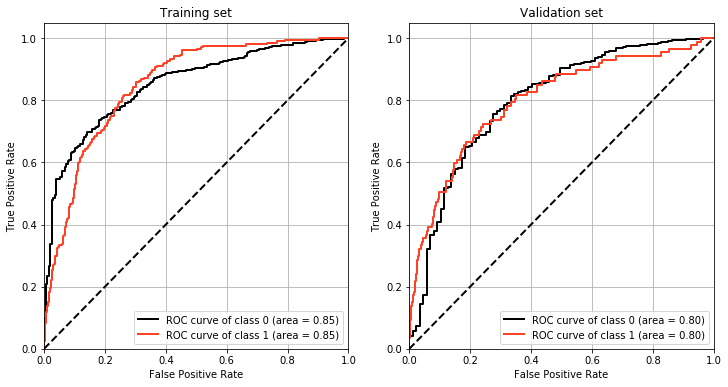

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model1.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.98      0.78      0.87      1812
          1       0.13      0.69      0.22        87

avg / total       0.94      0.78      0.84      1899



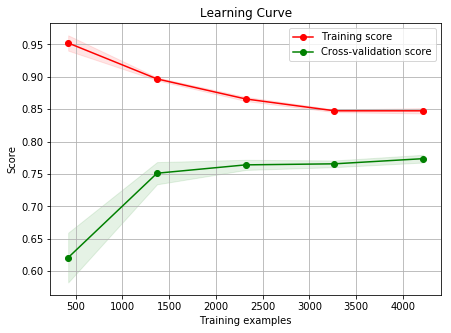

In [42]:
skplt.estimators.plot_learning_curve(model1, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.2. Support Vector Machine (Radial Basis Function Kernel) <font>

In [47]:
from sklearn.svm import SVC

model2 = SVC(probability=True, kernel='rbf', class_weight='balanced', C=0.5, max_iter=50000,
             shrinking=True).fit(X_train_std, Y_train)

probas_train = model2.predict_proba(X_train_std)
probas_val = model2.predict_proba(X_val_std)

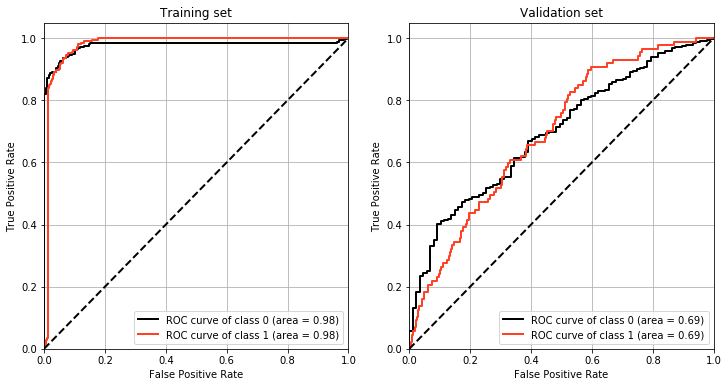

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model2.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.96      0.87      0.91      1812
          1       0.10      0.30      0.15        87

avg / total       0.92      0.84      0.88      1899



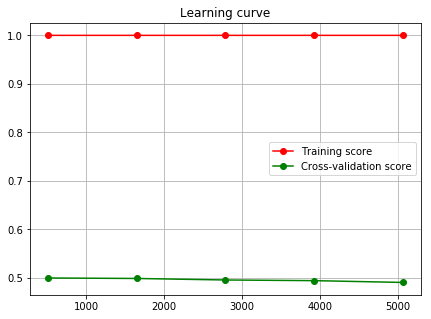

In [50]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model2, X, Y, cv=5,
                                                        scoring='roc_auc', n_jobs=1,
                                                        train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.title('Learning curve')
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

***

### <font color='green'> 3.3. Support Vector Machine (Linear Kernel) <font>

In [56]:
from sklearn.svm import SVC

model3 = SVC(probability=True, kernel='linear', class_weight='balanced', C=0.5, max_iter=50000,
             shrinking=True).fit(X_train_std, Y_train)

probas_train = model3.predict_proba(X_train_std)
probas_val = model3.predict_proba(X_val_std)

C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


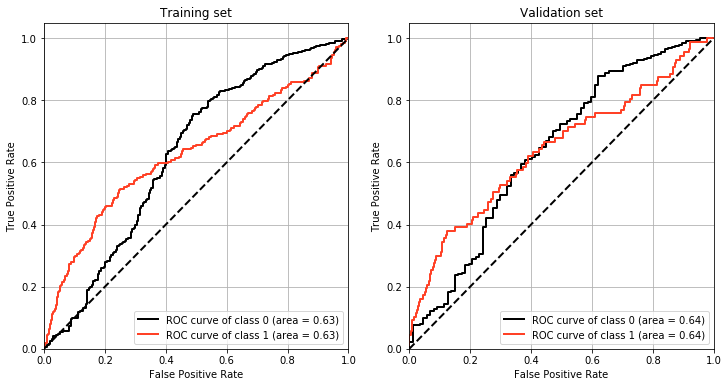

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model3.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.97      0.22      0.36      1812
          1       0.05      0.85      0.09        87

avg / total       0.93      0.25      0.35      1899



C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver termin

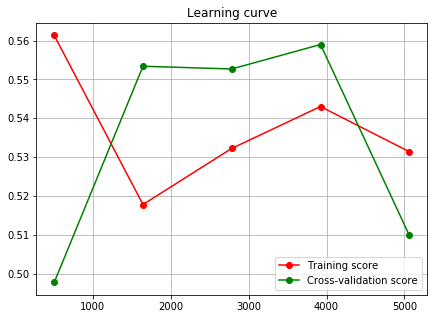

In [54]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model3, X, Y, cv=5,
                                                        scoring='roc_auc', n_jobs=1,
                                                        train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.title('Learning curve')
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

***

### <font color='green'> 3.4. Naive Bayes <font>

In [60]:
from sklearn.naive_bayes import GaussianNB

model4 = GaussianNB()
model4.fit(X_train_std, Y_train)

probas_train = model4.predict_proba(X_train_std)
probas_val = model4.predict_proba(X_val_std)

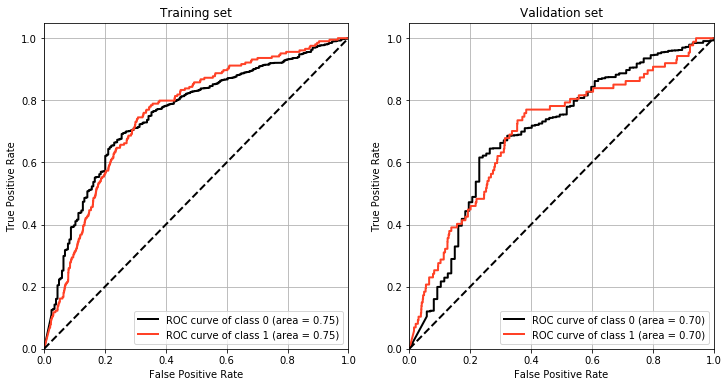

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model4.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.97      0.74      0.84      1812
          1       0.09      0.54      0.15        87

avg / total       0.93      0.73      0.81      1899



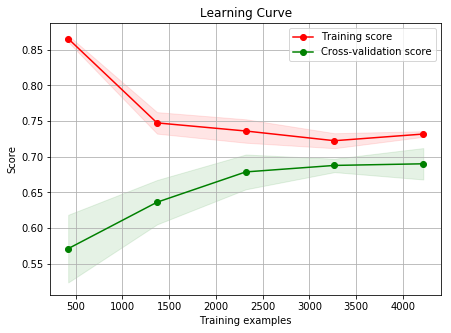

In [63]:
skplt.estimators.plot_learning_curve(model4, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.5. CART <font>

In [65]:
from sklearn.tree import DecisionTreeClassifier

model5 = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=30).fit(X_train_std, Y_train)
model5

probas_train = model5.predict_proba(X_train_std)
probas_val = model5.predict_proba(X_val_std)

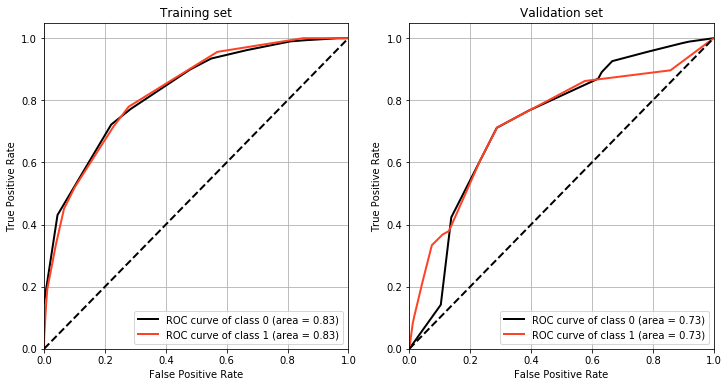

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model5.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98      1812
          1       0.25      0.01      0.02        87

avg / total       0.92      0.95      0.93      1899



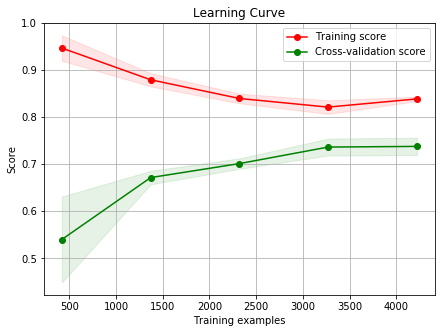

In [68]:
skplt.estimators.plot_learning_curve(model5, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***



### <font color='green'> 3.6. Gradient Boosting Classifier <font>

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
model6 = GradientBoostingClassifier(max_depth=4, learning_rate=0.01, n_estimators=5000, max_features=40,
                                    min_samples_split=2).fit(X_train_std, Y_train)

probas_train = model6.predict_proba(X_train_std)
probas_val = model6.predict_proba(X_val_std)

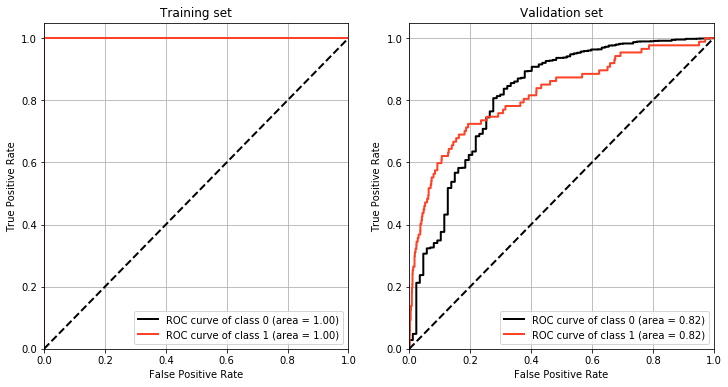

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model6.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1812
          1       0.53      0.09      0.16        87

avg / total       0.94      0.95      0.94      1899



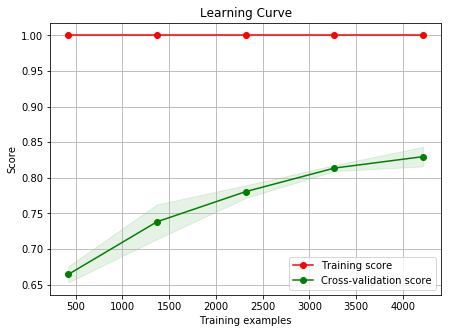

In [76]:
skplt.estimators.plot_learning_curve(model6, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.7. Extreme Gradient Boosting with XGBoost <font>

**Model fitting**

In [77]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [78]:
model7 = XGBClassifier(booster='dart', n_estimators=1000, learning_rate=0.05, max_depth=3,
                       min_child_weight=0.1, reg_alpha=2.0, reg_lambda=2.0)

#model = XGBClassifier(booster='dart', n_estimators=10000, learning_rate=0.05, learning_lambda=3.0,
#                      min_child_weight=0.1, eval_metric='auc', seed=0, max_depth=3)

eval_set  = [(X_train_std, Y_train), (X_val_std, Y_val)]

model7 = model7.fit(X_train_std, np.ravel(Y_train), eval_set=eval_set,
                    eval_metric='auc', early_stopping_rounds=100)

[0]	validation_0-auc:0.701751	validation_1-auc:0.720846
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.704618	validation_1-auc:0.720846
[2]	validation_0-auc:0.760875	validation_1-auc:0.740834
[3]	validation_0-auc:0.760879	validation_1-auc:0.740834
[4]	validation_0-auc:0.760883	validation_1-auc:0.740834
[5]	validation_0-auc:0.762908	validation_1-auc:0.740834
[6]	validation_0-auc:0.768802	validation_1-auc:0.743641
[7]	validation_0-auc:0.769672	validation_1-auc:0.743853
[8]	validation_0-auc:0.779242	validation_1-auc:0.749442
[9]	validation_0-auc:0.781849	validation_1-auc:0.751532
[10]	validation_0-auc:0.782741	validation_1-auc:0.752937
[11]	validation_0-auc:0.78293	validation_1-auc:0.75229
[12]	validation_0-auc:0.805338	validation_1-auc:0.764834
[13]	validation_0-auc:0.803959	validation_1-auc:0.767178
[14]	validation_0-auc:0.809094	validation_1-auc:0.770381

In [79]:
print(model7.best_score)
print(model7.best_iteration)

0.850159
288


In [80]:
probas_train = model7.predict_proba(X_train_std)
probas_val = model7.predict_proba(X_val_std)

**Feature importance**

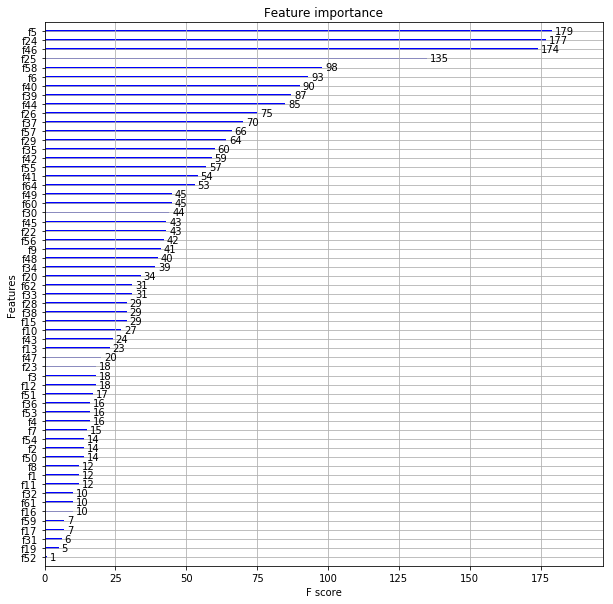

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model7, ax=ax, color='blue')
plt.show()

**ROC Curves and Metrics**

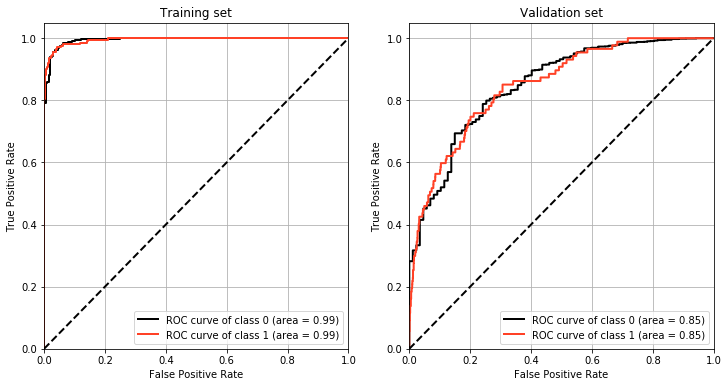

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model7.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1812
          1       0.83      0.06      0.11        87

avg / total       0.95      0.96      0.94      1899



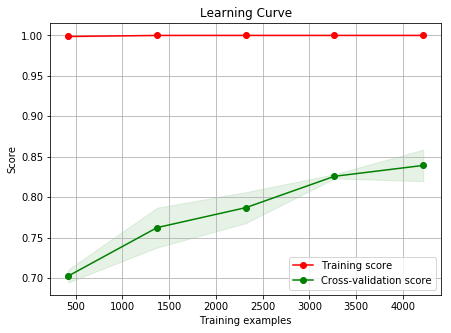

In [84]:
skplt.estimators.plot_learning_curve(model7, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.8. Extreme Gradient Boosting with Light GBM <font>

https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

Image explaining the difference between XGBoost and Light GBM:

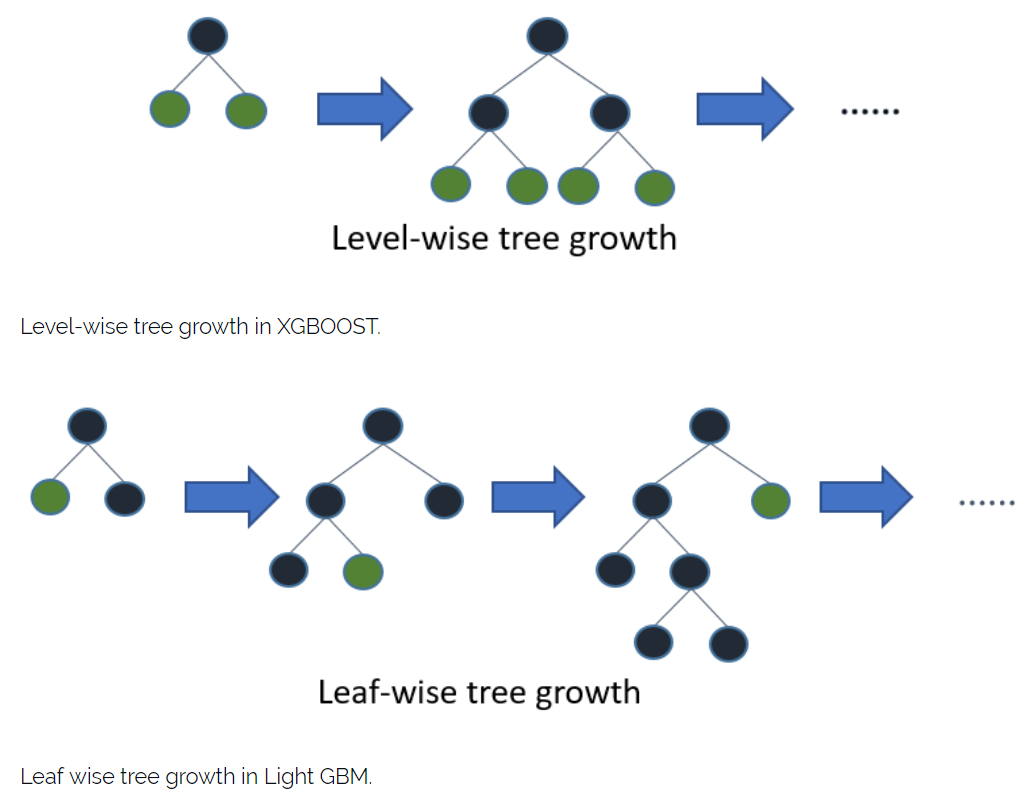

In [149]:
from IPython.display import Image
Image(filename="Light GBM.png", height=600, width=600)

Hyperparameters:

http://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters

`lightgbm.train(params, train_set, num_boost_round=100, valid_sets=None, valid_names=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, evals_result=None, verbose_eval=True, learning_rates=None, keep_training_booster=False, callbacks=None)`

In [85]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train_std, label=Y_train)
d_val = lgb.Dataset(X_val_std, label=Y_val, reference=d_train)
evals_result = {}

params = {}
params['learning_rate'] = 0.02
params['boosting_type'] = 'dart'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['reg_lambda'] = 3.0
params['reg_alpha'] = 3.0
params['max_depth'] = 4
params['random_state'] = 0
params['class_weight '] = 'is_unbalance'
params['subsample'] = 0.7
params['num_leaves'] = 20
params['min_split_gain'] = 0.001
params['drop_rate'] = 0.6
params['max_drop'] = 20
params['feature_fraction'] = 0.7
#params['min_data_in_leaf'] = 30
params['min_sum_hessian_in_leaf'] = 1e-4

model8 = lgb.train(params, d_train, num_boost_round=3700, valid_sets=[d_train, d_val],
                 early_stopping_rounds=1000, evals_result=evals_result, verbose_eval=100)

pred_train = model8.predict(X_train_std, num_iteration=model8.best_iteration)
pred_val = model8.predict(X_val_std, num_iteration=model8.best_iteration)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.791254	valid_1's auc: 0.773667
[200]	training's auc: 0.829956	valid_1's auc: 0.791901
[300]	training's auc: 0.870869	valid_1's auc: 0.823552
[400]	training's auc: 0.896889	valid_1's auc: 0.830723
[500]	training's auc: 0.915117	valid_1's auc: 0.834726
[600]	training's auc: 0.933516	valid_1's auc: 0.840165
[700]	training's auc: 0.949782	valid_1's auc: 0.844583
[800]	training's auc: 0.959653	valid_1's auc: 0.844336
[900]	training's auc: 0.967428	valid_1's auc: 0.844031
[1000]	training's auc: 0.973206	valid_1's auc: 0.844869
[1100]	training's auc: 0.978514	valid_1's auc: 0.844932
[1200]	training's auc: 0.983167	valid_1's auc: 0.847343
[1300]	training's auc: 0.98664	valid_1's auc: 0.848573
[1400]	training's auc: 0.98973	valid_1's auc: 0.846975
[1500]	training's auc: 0.992029	valid_1's auc: 0.847609
[1600]	training's auc: 0.994262	valid_1's auc: 0.846639
[1700]	training's auc: 0.995821	valid_1's auc: 0.84

In [86]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=Y_train, y_score=pred_train))
print(roc_auc_score(y_true=Y_val, y_score=pred_val))

0.991582802075
0.840453807313


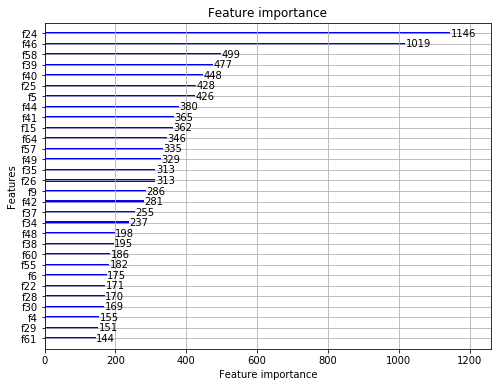

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
ax = lgb.plot_importance(model8, max_num_features=30, ax=ax, color='blue')
plt.show()

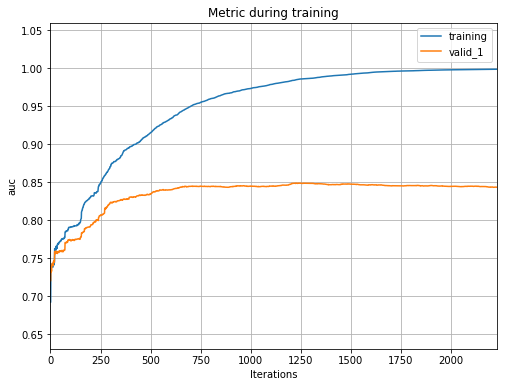

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
ax = lgb.plot_metric(evals_result, metric='auc', ax=ax)
plt.show()

**Alternate expression**

The previous version is not compatible with many features provided by the scikitplot functions. This sklearn version is however comptabible with scikitplot functions.

We use the DART booster which introduces neural net-like dropouts in the tree learning for regularization purposes.

In [91]:
import lightgbm as lgb

In [94]:
from lightgbm import LGBMClassifier

eval_set  = [(X_train_std, Y_train), (X_val_std, Y_val)]

model8 = LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=1000, learning_rate=0.05,
                      max_depth=3, objective='binary', reg_alpha=3.0, drop_rate=0.7, num_leaves=30, feature_fraction=0.7,
                      min_split_gain=0.001, reg_lambda=3.0, min_sum_hessian_in_leaf=0.001, min_child_samples=30,
                      max_drop=30)

# 0.864555 / 0.85
# model = LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=10000, learning_rate=0.05,
#                      max_depth=4, objective='binary', reg_alpha=2.0, drop_rate=0.6, num_leaves=30, feature_fraction=0.5,
#                      min_split_gain=0.001, reg_lambda=2.0, min_sum_hessian_in_leaf=0.001)

model8.fit(X_train_std, Y_train, eval_metric=['auc'], eval_set=eval_set, early_stopping_rounds=750)

[1]	training's auc: 0.789107	valid_1's auc: 0.762179
Training until validation scores don't improve for 750 rounds.
[2]	training's auc: 0.800497	valid_1's auc: 0.764752
[3]	training's auc: 0.802601	valid_1's auc: 0.769148
[4]	training's auc: 0.819743	valid_1's auc: 0.778866
[5]	training's auc: 0.824281	valid_1's auc: 0.780781
[6]	training's auc: 0.825549	valid_1's auc: 0.78205
[7]	training's auc: 0.833051	valid_1's auc: 0.780182
[8]	training's auc: 0.833028	valid_1's auc: 0.780366
[9]	training's auc: 0.839536	valid_1's auc: 0.784749
[10]	training's auc: 0.839046	valid_1's auc: 0.78329
[11]	training's auc: 0.839004	valid_1's auc: 0.783103
[12]	training's auc: 0.838667	valid_1's auc: 0.782891
[13]	training's auc: 0.843988	valid_1's auc: 0.787968
[14]	training's auc: 0.843782	valid_1's auc: 0.787461
[15]	training's auc: 0.84568	valid_1's auc: 0.784311
[16]	training's auc: 0.85251	valid_1's auc: 0.789228
[17]	training's auc: 0.852517	valid_1's auc: 0.786909
[18]	training's auc: 0.853553	va

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=1.0, drop_rate=0.7, feature_fraction=0.7,
        learning_rate=0.05, max_depth=3, max_drop=30, min_child_samples=30,
        min_child_weight=0.001, min_split_gain=0.001,
        min_sum_hessian_in_leaf=0.001, n_estimators=1000, n_jobs=-1,
        num_leaves=30, objective='binary', random_state=None,
        reg_alpha=3.0, reg_lambda=3.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [95]:
from sklearn.metrics import roc_auc_score

probas_train = model8.predict_proba(X_train_std)[:,1]
probas_val = model8.predict_proba(X_val_std)[:,1]

print(roc_auc_score(y_true=Y_train, y_score=probas_train))
print(roc_auc_score(y_true=Y_val, y_score=probas_val))

0.998748410865
0.852874197559


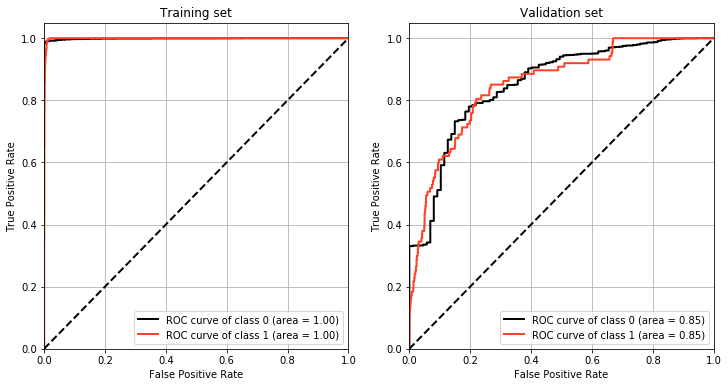

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, model8.predict_proba(X_train_std), curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, model8.predict_proba(X_val_std), curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

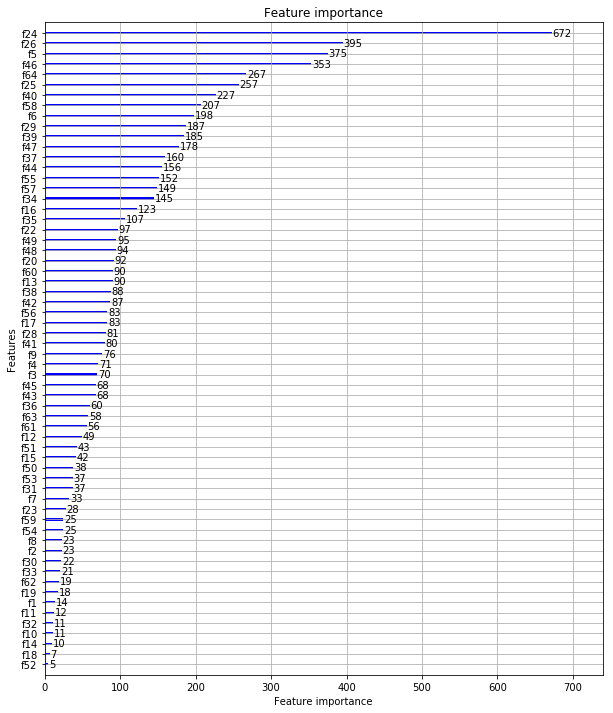

In [102]:
fig, ax = plt.subplots(figsize=(10,12))
ax = lgb.plot_importance(model8, max_num_features=len(X_train.columns), ax=ax, color='blue')
plt.show()

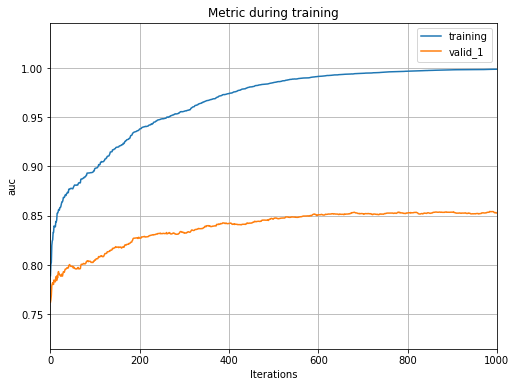

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
ax = lgb.plot_metric(model8.evals_result_, metric='auc', ax=ax)
plt.show()

In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model8.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.98      0.92      0.95      1812
          1       0.25      0.55      0.34        87

avg / total       0.94      0.90      0.92      1899



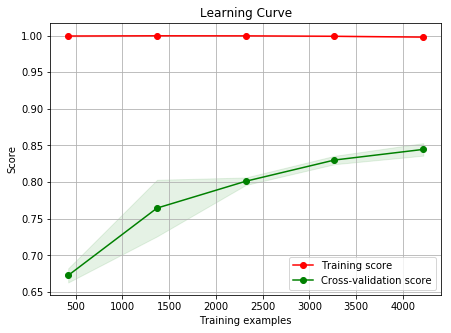

In [105]:
skplt.estimators.plot_learning_curve(model8, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.9. Neural Networks (Multilayer Perceptron)<font>

In [106]:
from sklearn.neural_network import MLPClassifier

model9 = MLPClassifier(hidden_layer_sizes=(80,), activation='relu', learning_rate_init=0.01,
                      max_iter=1000000, learning_rate='adaptive', alpha=0.01, solver='adam')
model9.fit(X_train_std, Y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=1000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [107]:
probas_train = model9.predict_proba(X_train_std)
probas_val = model9.predict_proba(X_val_std)

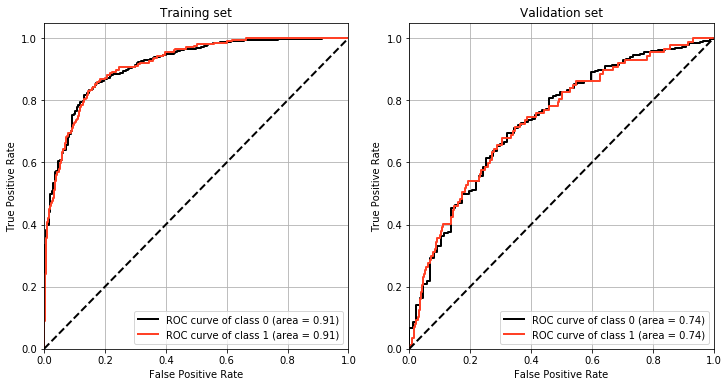

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model9.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1812
          1       0.12      0.03      0.05        87

avg / total       0.92      0.94      0.93      1899



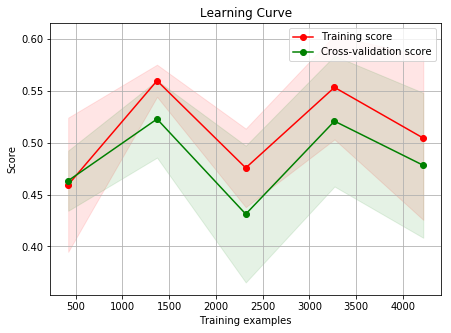

In [110]:
skplt.estimators.plot_learning_curve(model9, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

***

### <font color='green'> 3.10. Linear Discriminant Analysis <font>

In [111]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model10 = LinearDiscriminantAnalysis()
model10.fit(X_train_std, Y_train)

C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [112]:
probas_train = model10.predict_proba(X_train_std)
probas_val = model10.predict_proba(X_val_std)

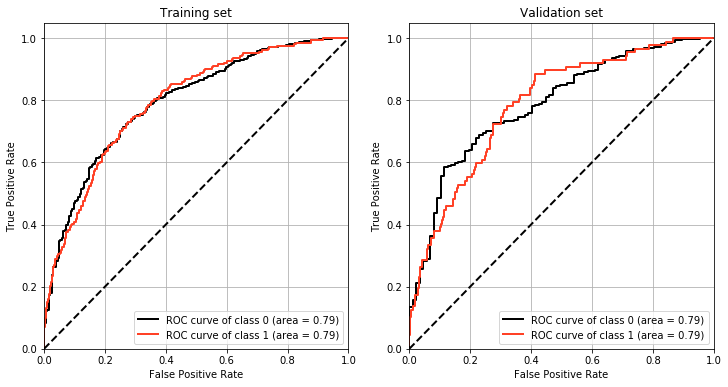

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

skplt.metrics.plot_roc_curve(Y_train, probas_train, curves='each_class', ax=axes[0], cmap='CMRmap')
axes[0].set_title('Training set')
axes[0].grid(True)

skplt.metrics.plot_roc_curve(Y_val, probas_val, curves='each_class', ax=axes[1], cmap='CMRmap')
axes[1].set_title('Validation set')
axes[1].grid(True)

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_true=Y_val, y_pred=model10.predict(X_val_std)))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1812
          1       0.34      0.13      0.18        87

avg / total       0.93      0.95      0.94      1899



C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are colli

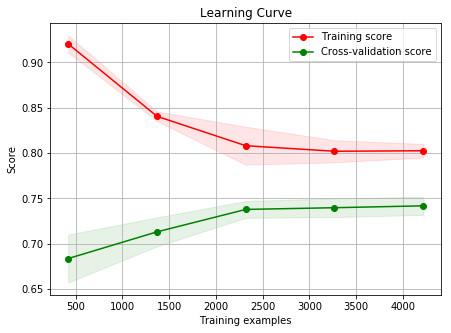

In [116]:
skplt.estimators.plot_learning_curve(model10, X, Y, scoring='roc_auc', figsize=(7,5))
plt.show()

## <font color='red'> 4. Model review and interpretation <font>

### <font color='green'> 4.1. Model review <font>

The main metrics for model selection will be the following:

- **ROC curve (validation set)**: this will be the main metric for our model selection. It is well suited for imbalanced datasets (95% for class 0 and 5% for class 1), as we need to test a model's predictive capabilities for varying thresholds. We also only check the ROC curve on the validation set, the set we will use for model validation (not calibration).
- **Learning curves (cross-validation)**: done in cross-validation, this is to very useful as it helps us indicate if a model will generalize well should we feed it with less data. We will use the ROC curve as the main metric.

In [127]:
model_names = ['LR', 'RBF-SVM', 'L-SVM', 'NB', 'CART',
               'GBT', 'XGBoost', 'Light GBM', 'MLP', 'LDA']

model_list = [model1, model2, model3, model4, model5,
              model6, model7, model8, model9, model10]
roc_auc_scores = []

for model in model_list:
    temp = model.predict_proba(X_val_std)[:,1]
    roc_auc_scores.append(roc_auc_score(y_true=Y_val, y_score=temp))
    
review = pd.DataFrame(roc_auc_scores, index=model_names, columns=['ROC'])
review

,ROC
LR,0.798349
RBF-SVM,0.693956
L-SVM,0.641318
NB,0.697001
CART,0.730060
GBT,0.816907
XGBoost,0.848732
Light GBM,0.852874
MLP,0.735302
LDA,0.786043


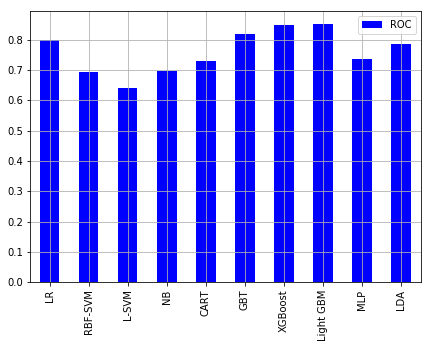

In [132]:
review.plot(kind='bar', figsize=(7,5), color='blue', grid=True)
plt.show()

Let's check each model:

- ***Logistic regression (LR)***: the model performance is surprisingly decent, considering that logistic regression is a linear model for classification, with a ROC curve of **0.79** on the validation set. By checking the cross-validation learning curves, we can explain this by the fact that while the logistic regression doesn't fit (or calibrate) perfectly on the training set, it has the advatangeous benefit of being less susceptible to overfitting. It will thus generalize better for new datapoints (here the validation set).


-  ***Radial basis function kernel - SVM (RBF-SVM)***: the SVM with radial basis function (RBF) kernel underperforms logistic regression with a ROC Curve of **0.69**. The learning curves reveal that cross-validation ROC curve is even worse, never going over 0.5. Does this indicate that SVMs perform poorly on class unbalanced datasets? One more likely explication is that the SVM's performance is likely to be dictated by the choice of kernel function. Here we chose the Radial Basis Basis Kernel, which is a specific higher dimensional mapping that is unlikely to be the ideal mapping.


-  ***Linear kernel - SVM (L-SVM)***: performance is even worse than the SVM with RBF as its kernel (**0.64**). This is interesting because the Linear SVM is stated to be similar to logistic regression. While the logistic regression relies on a probabilistic framework for learning, the SVM uses a geometric framework of maximum margin classification. Could this be because SVMs perform poorly on class unbalanced datasets?


- ***Naive Bayes (NB)***: gives a decent performance of **0.70**. This simple model not only has the advantage of being one of the fastest of the Scikit-Learn models to train in this model review, it gives a decent performance for a relatively simple algorithm with almost no hyperparameters to tune in with and the assumption that all the features are conditionally independent.


-  ***Decision tree classifier (CART)***: underperforms logistic regression (**0.73**), which is not supprising since decision trees are prone to overfitting. The use of additive/boosting methods from ensemble learning will help improve model performance through an unweighted/weighted average of decision trees.


-  ***Gradient boosting classifier (GBT)***: the first model to outperform logistic regression (**0.81**), which is consistent with research litterature on the advantage of using a weighted average of sequentially learned decision trees.


-  ***Extreme gradient boosting classifier (XGBoost)***: developped by Tianqi Chen, XGBoost is a popular extreme gradient boosting algorithm heavily used in Kaggle Competitions. One of its main benefits is the number of hyperparameters one can tune and the possibility for early stopping of learning. In addition to faster learning, XGBoost usually produces better results than Scikit-Learn's Gradient Boosting Classifier since XGBoost's framework gives the user more control over regularization. In particular, the use of the DART booster setting in the XGBoost (developped by Rashmi Korlakai Vinayak and Ran Gilad-Bachrach) allows for dropouts in the learning (similar to those from neural networks). Performance in our review gave **0.84**.


-  ***Extreme gradient boosting classifier (Light GBM)***: Light GBM is almost identical to XGBoost. The main difference between XGBoost and Light GBM stems from a different approach in growing the decision trees. Since it prioritizes the direction where tree depth should be expanded thus decreasing the loss function at a much faster rate, it can be prone to overfitting but also leads to faster implementations. This is however handled by the regularizations parameters (ex. DART, dropouts, L1, L2). Performance in our review gave **0.85**.


-  ***Multilayer Perceptron (MLP)***: the ROC Curve of **0.73** underperforms logistic regression. The main concern however with MLP is its dreadful learning curves, which indicate that it generalizes really poorly to new data. The lack of data is probably the main cause for its low predictive performance.


-  ***Linear Discriminant Analysis (LDA)***: the LDA is the other major linear model for classification. It only underforms slightly compared to logistic regression, both on its ROC curve (**0.78**) and its learning curves.


This leaves us with 3 ensemble learning models (who outperformed logistic regression) to pick from:

- *Gradient Boosting*
- *Extreme Gradient Boosting (XGBoost)*
- *Extreme Gradient Boosting (Light GBM)*

The user decided to use **Light GBM** for Kaggle test set submissions. This stems from previous tests and Kaggle submissions which showed that Light GBM was more consistent than XGBoost (results for Light GBM usually landed between Kaggle ROC curves of **0.81** and **0.85**).

### <font color='green'> 4.2. Interpretation <font>

One of the main advantages of decision tree models is their interpretability and Light GBM as an ensemble learning model for decision trees gives an option to check for **feature importance** (number of total splits triggered by a feature):

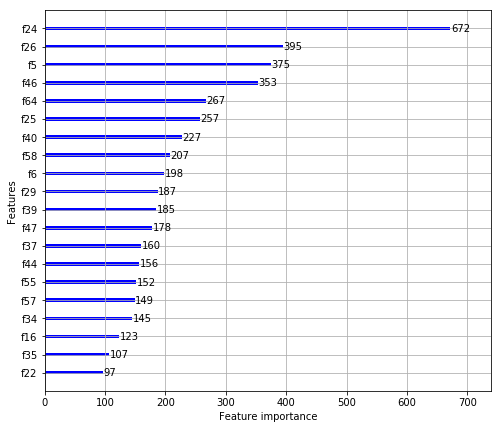

In [153]:
fig, ax = plt.subplots(figsize=(8,7))
ax = lgb.plot_importance(model8, max_num_features=20, ax=ax, color='blue')
plt.title('')
plt.show()

From this plot, we can emphasize the main drivers of bankcruptcy among those Polish companies:

- **f24**: `gross profit (in 3 years) / total assets`. This is Novy-Marx’s test for quality growth, with higher ratios indicating that the company is capable of managing its manufacturing costs and ensuring profitability.
- **f26**: `(net profit + depreciation) / total liabilities`. This is a liquidity/debt ratio which indicates how well a company is capable of paying off its debts through its net profit.
- **f5**: `cash / (operating expenses - depreciation)`. Indicates how the company's is able to pay off its expenses unrelated to its main production (payroll, rent, office supplies, utilities, marketing, insurance, taxes).
- **f46**: `(current assets - inventory) / short-term liabilities`. This is a liquidity ratio that measures how well a company is able to pay off its short-term debts.
- **f64**: `sales / fixed assets`. Fixed-asset turnover, indicates how well a company is able to generate sales out of its fixed assets.
- **f25**: `(equity - share capital) / total assets`. This is an indicator of the company's leverage capabilities, when used to finance the firm.
- **f40**: `(current assets - inventories) / long-term liabilities`. This is similar to f46, except that now it measures a company's ability to pay off its long-term debts, making it more of a debt ratio.
- **f58**: `total costs / total sales`. Efficiency ratio, how well a company is able to be productive.
- **f6**: `retained earnings / total assets`. Cumulative profitability over time as a proportion of total assets.
- **f29**: `logarithm of total assets`. Possibly used in combination with other ratios through the decision trees' nonlinear decision-making reasoning.

From the ranking of feature importance, we observe that the **profitability ratio** `gross profit (in 3 years) / total assets` is a highly recurring predictor of corporate bankcruptcy in the case of Polish companies, which intuitively makes sense in the case of those Polish companies as weak profitability is likely to increase default risk. Important ratios also include **cash/liquidity ratios** (f26, f5, f46, f40) and ratios that generally describe how well a company generates enough profit to cover its operating expenses and shareholders' expectations.

How could we improve over 0.85 ? Through the creation of synthetic features. This is supported by running a cross-validation recursive feature elimination algorithm on our Light GBM Extreme Gradient Boosting model:

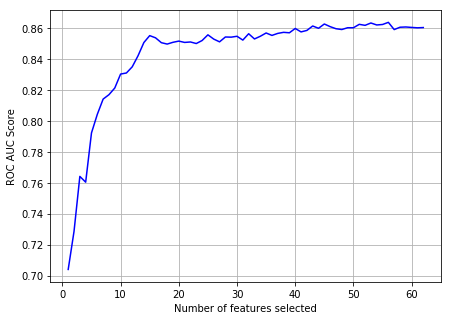

In [135]:
from sklearn.feature_selection import RFE, RFECV
rfecv = RFECV(estimator=model8, step=1, cv=5, scoring='roc_auc').fit(X, Y)

plt.figure(figsize=(7,5))
plt.xlabel("Number of features selected")
plt.ylabel("ROC AUC Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='blue')
plt.grid(True)
plt.show()

This means that there is likely room for more features to be utilized through **synthetic feature creation**. Due to time constraints, the user was unable to properly implement algorithms to generate synthetic features, as indicated by researchers from the Department of Computer Science and Operations Research of Wroclaw University of Science and Technology: Zieba M., Tomczak S. K. and Tomczak J. M.'s *Ensemble Boosted Trees with Synthetic Features Generation in Application to Bankcruptcy Prediction* (2016).

Those authors used the same set of 62 financial ratios and managed to reach a ROC Curve average of 0.95 on 5 different time periods with Extreme Gradient Boosting (XGBoost) and synthetic feature generation algorithms.

## <font color='red'> 5. Kaggle submission <font>

The final submission gave a ROC Curve of **0.85** (public leaderboard) and **0.81** (private leaderboard), under the username **SJD1882**.

In [138]:
model = model8
model

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=1.0, drop_rate=0.7, feature_fraction=0.7,
        learning_rate=0.05, max_depth=3, max_drop=30, min_child_samples=30,
        min_child_weight=0.001, min_split_gain=0.001,
        min_sum_hessian_in_leaf=0.001, n_estimators=1000, n_jobs=-1,
        num_leaves=30, objective='binary', random_state=None,
        reg_alpha=3.0, reg_lambda=3.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [139]:
def export_kaggle(df_test, proba_test, save=True, path_save="submission.csv"):
    """
    Export submissions with good kaggle format.
    df_test : (pandas dataframe) test set
    proba_test : (numpy ndarray) probabilities as numpy ndarray you get using method .predict_proba()[:,1]
    save : (bool) if set to True, it will save csv submission in path_save path.
    path_save : (str) path where to save submission.
    return : dataframe for submission
    """
    proba_serie = pd.Series(proba_test, index=df_test.index)
    df_submit = pd.concat([df_test["id"], proba_serie], axis=1)
    df_submit.columns = ["id", "decision"]
    df_submit.to_csv(path_save, index=False)
    return df_submit

In [140]:
# TEST PREDICTIONS
probas_test = model.predict_proba(X_test_std)[:,1]
probas_test.shape

(3466,)

In [77]:
# TEST PREDICTIONS (for LightGBM)
probas_test = model.predict(X_test_std)
probas_test.shape

(3466,)

In [141]:
probas_test

array([ 0.06418052,  0.47115173,  0.14256446, ...,  0.53219343,
        0.17864364,  0.21650561])

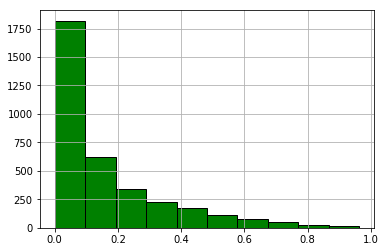

In [142]:
plt.hist(probas_test, color='green', edgecolor='black')
plt.grid(True)

In [143]:
df_test_original = pd.read_csv('test.csv')
df_submit = export_kaggle(df_test_original, probas_test, True)